In [7]:
# Creating the spark context

import os

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Local-Spark-App") \
    .config('spark.ui.proxyBase', '/proxy/4041') \
    .config('spark.sql.repl.eagerEval.enabled', False) \
    .config('spark.driver.memory', '4g') \
    .getOrCreate()


In [8]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType
from graphframes import GraphFrame

In [9]:
import gzip
import json

DIR = './'

def load_data_spark(file_name, head=500):
    # Read the JSON file into a Spark DataFrame
    df = spark.read.json(file_name)
    
    # Show the first 'head' rows of the DataFrame
    df.show(head)
    
    return df


In [10]:
import pandas as pd
import gzip
import requests
import json

# file_url = 'https://storage.googleapis.com/nyu-dataproc-hdfs-ingest/goodreads_book_authors.json.gz'

# file_url_interactions = 'https://storage.googleapis.com/nyu-dataproc-hdfs-ingest/goodreads_interactions_dedup.json.gz'
# Read the JSON file into a DataFrame
#df = spark.read.json(file_url)
# df = pd.read_json(file_url, lines = True)

# df_interactions = pd.read_json(file_url_interactions, lines = True, nrows=1)

file_url_interactions = 'https://storage.googleapis.com/nyu-dataproc-hdfs-ingest/goodreads_interactions_dedup.json.gz'

# Define the number of entries to fetch
entries_to_fetch = 1000000

# Initialize an empty list to store data
data = []

# Stream and process the JSON file iteratively
with requests.get(file_url_interactions, stream=True) as response:
    with gzip.open(response.raw, 'rb') as file:
        # Read the file line by line
        for line in file:
            # Break the loop if we have fetched the desired number of entries
            if len(data) >= entries_to_fetch:
                break
            
            # Decode the line
            decoded_line = line.decode('utf-8')
            
            # Load the JSON data
            json_data = json.loads(decoded_line)
            
            # Append the JSON data to the list
            data.append(json_data)

# Create a DataFrame from the collected data
df_interactions = pd.DataFrame(data)


df_interactions.head()


,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,34684622,a53868823f065a0e20fd4ae98b820674,False,0,,Tue Oct 17 09:40:11 -0700 2017,Tue Oct 17 09:40:12 -0700 2017,,
1,8842281e1d1347389f2ab93d60773d4d,34536488,9f08c5f991f87f3b7ae4ce779c2aac10,False,0,,Fri Oct 13 07:19:50 -0700 2017,Fri Oct 13 07:19:50 -0700 2017,,
2,8842281e1d1347389f2ab93d60773d4d,34017076,14da595c5b0c38b1247888f62f74a772,False,0,,Fri Oct 06 09:32:42 -0700 2017,Fri Oct 06 09:32:43 -0700 2017,,
3,8842281e1d1347389f2ab93d60773d4d,71730,bd1a29916eb3ea1d0d45d4f7395920c5,False,0,,Tue Oct 03 23:31:03 -0700 2017,Tue Oct 03 23:39:42 -0700 2017,,
4,8842281e1d1347389f2ab93d60773d4d,30422361,d2edf29508fd36808bf30b37043acda4,False,0,,Tue Oct 03 15:05:28 -0700 2017,Tue Oct 03 15:05:29 -0700 2017,,


In [11]:
# import gzip
# import requests
# import json
# import threading
# import pandas as pd
# from confluent_kafka import Producer

# file_url_interactions = 'https://storage.googleapis.com/nyu-dataproc-hdfs-ingest/goodreads_interactions_dedup.json.gz'

# # Kafka producer configuration
# producer_conf = {
#     'bootstrap.servers': 'your_bootstrap_servers',  # Replace with your Kafka bootstrap servers
#     'client.id': 'file_stream_producer'
# }

# # Kafka topic to produce messages to
# kafka_topic = 'your_kafka_topic'  # Replace with your Kafka topic

# # Define the number of entries to fetch
# entries_to_fetch = 1000

# # Initialize an empty list to store data
# data = []

# # Stream and process the JSON file iteratively
# def stream_to_kafka():
#     producer = Producer(producer_conf)

#     with requests.get(file_url_interactions, stream=True) as response:
#         with gzip.open(response.raw, 'rb') as file:
#             # Read the file line by line
#             for line in file:
#                 # Break the loop if we have fetched the desired number of entries
#                 if len(data) >= entries_to_fetch:
#                     break
                
#                 # Decode the line
#                 decoded_line = line.decode('utf-8')
                
#                 # Load the JSON data
#                 json_data = json.loads(decoded_line)
                
#                 # Append the JSON data to the list
#                 data.append(json_data)

#                 # Emulate Kafka message key (can be modified as needed)
#                 key = 'file_stream_key'

#                 # Send the data as Kafka messages
#                 producer.produce(kafka_topic, key=key, value=decoded_line)

#                 # Simulate a delay to mimic streaming
#                 producer.flush()
#                 time.sleep(0.1)  # Adjust this delay as needed

#     # Close the producer after streaming completes
#     producer.flush()
#     producer.close()

# # Start streaming data to Kafka in a separate thread
# stream_thread = threading.Thread(target=stream_to_kafka)
# stream_thread.start()

# # Wait for a limited time to let the streaming thread execute (optional)
# stream_thread.join(timeout=60)  # Wait for 60 seconds, adjust as needed

# # Create a DataFrame from the collected data (for local processing or validation)
# df_interactions = pd.DataFrame(data)

# # Display the DataFrame head (optional)
# df_interactions.head()


In [12]:
spark_interactions = spark.createDataFrame(df_interactions)
spark_interactions.show()

+--------------------+--------+--------------------+-------+------+----------------------+--------------------+--------------------+--------------------+--------------------+
|             user_id| book_id|           review_id|is_read|rating|review_text_incomplete|          date_added|        date_updated|             read_at|          started_at|
+--------------------+--------+--------------------+-------+------+----------------------+--------------------+--------------------+--------------------+--------------------+
|8842281e1d1347389...|34684622|a53868823f065a0e2...|  false|     0|                      |Tue Oct 17 09:40:...|Tue Oct 17 09:40:...|                    |                    |
|8842281e1d1347389...|34536488|9f08c5f991f87f3b7...|  false|     0|                      |Fri Oct 13 07:19:...|Fri Oct 13 07:19:...|                    |                    |
|8842281e1d1347389...|34017076|14da595c5b0c38b12...|  false|     0|                      |Fri Oct 06 09:32:...|Fri Oct 06 09:

In [13]:
from pyspark.sql.functions import col 

columns = ["user_id", "book_id", "review_id", "is_read", "rating", "review_text_incomplete", "date_added", "date_updated", "read_at", "started_at"]

average_rating_per_user = spark_interactions.groupBy("user_id").agg({"rating": "avg"})

# Counting the number of books read per user
books_read_per_user = spark_interactions.filter(col("is_read") == True).groupBy("user_id").count()

# Perform more analysis as needed based on your requirements

# Show the results
average_rating_per_user.show()


+--------------------+-------------------+
|             user_id|        avg(rating)|
+--------------------+-------------------+
|c8bf6c854005db63d...|  3.022922636103152|
|ec34d1dce411b82ed...|0.46167883211678834|
|01d02898170634e6e...| 2.1682242990654204|
|d4b1dcb35db677f20...|  1.859016393442623|
|01608badf9aa27fa9...| 1.7023809523809523|
|3ee33629dd7ad241c...| 3.9537037037037037|
|220ef9c058a2132e6...|  4.021231422505308|
|cc8c48d41aea15e76...|  3.060931899641577|
|d986f354a045ffb91...|0.47249190938511326|
|8a9ac613452d39e70...|   2.19672131147541|
|8b5b85f0fc2c1873e...|   1.90561797752809|
|af157d0205b8a901d...| 2.2016129032258065|
|0b9a0d35734107c5d...| 2.6658476658476657|
|8ecbc8ba108ccf1be...|  2.808139534883721|
|854d7eea57ee70acf...| 1.3905882352941177|
|8489357f2f485c1a9...|  2.257142857142857|
|e65bfb998920844f2...|  4.445652173913044|
|d3ff4e7d9815e18e5...| 1.8727272727272728|
|7f63deefeec24f4f8...| 0.9945848375451264|
|a3a4e571b82e9395d...| 2.5082872928176796|
+----------

In [14]:
books_read_per_user.show()

+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|c8bf6c854005db63d...|  287|
|ec34d1dce411b82ed...|   53|
|01d02898170634e6e...|   64|
|d4b1dcb35db677f20...|  329|
|01608badf9aa27fa9...|  128|
|3ee33629dd7ad241c...|  102|
|220ef9c058a2132e6...|  406|
|cc8c48d41aea15e76...|  241|
|d986f354a045ffb91...|  108|
|8a9ac613452d39e70...|   92|
|8b5b85f0fc2c1873e...|  237|
|af157d0205b8a901d...|   75|
|0b9a0d35734107c5d...|  302|
|8ecbc8ba108ccf1be...|  149|
|854d7eea57ee70acf...|  163|
|8489357f2f485c1a9...|  136|
|e65bfb998920844f2...|   92|
|d3ff4e7d9815e18e5...|  124|
|7f63deefeec24f4f8...|  177|
|a3a4e571b82e9395d...|  103|
+--------------------+-----+
only showing top 20 rows



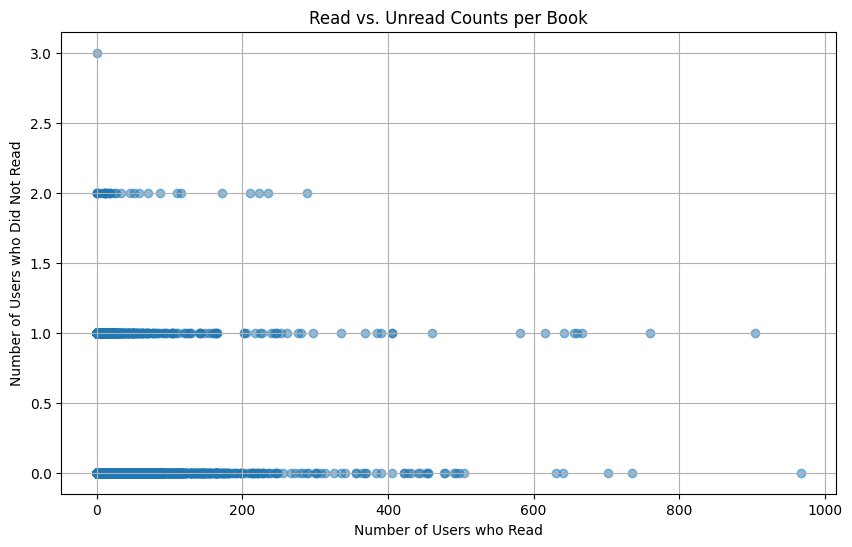

In [15]:
import matplotlib.pyplot as plt

filtered_data = spark_interactions.filter((spark_interactions['rating'] != 0) | (spark_interactions['review_text_incomplete'] != ''))

read_counts = filtered_data.filter(filtered_data['is_read'] == 'true') \
    .groupBy('book_id') \
    .agg({'user_id': 'count'}) \
    .withColumnRenamed('count(user_id)', 'read_count')

# Group by book_id and count distinct users who haven't read the book
unread_counts = filtered_data.filter(filtered_data['is_read'] == 'false') \
    .groupBy('book_id') \
    .agg({'user_id': 'count'}) \
    .withColumnRenamed('count(user_id)', 'unread_count')

# Join both counts on book_id
book_read_status = read_counts.join(unread_counts, 'book_id', 'outer').na.fill(0)

# Convert Spark DataFrame to Pandas DataFrame for visualization
book_read_pd = book_read_status.toPandas()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(book_read_pd['read_count'], book_read_pd['unread_count'], alpha=0.5)
plt.title('Read vs. Unread Counts per Book')
plt.xlabel('Number of Users who Read')
plt.ylabel('Number of Users who Did Not Read')
plt.grid(True)
plt.show()

In [16]:
selected_data = filtered_data.select('book_id', 'rating', 'is_read')

filtered_data.count()

473974

In [17]:
from pyspark.sql.functions import col, window

# Filter data for the user with the maximum book reads
filtered_df = spark_interactions.filter(
    (col('is_read') == 'true') &
    (col('read_at') != '') & (col('read_at') != 'NULL') &
    (col('started_at') != '') & (col('started_at') != 'NULL')
)

filtered_df.count()

152574

In [18]:
filtered_df.show(truncate=False)

+--------------------------------+--------+--------------------------------+-------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|user_id                         |book_id |review_id                       |is_read|rating|review_text_incomplete                                                                                                                                                             

In [19]:
from pyspark.sql.functions import count, desc

book_counts = filtered_df.groupBy('user_id').agg(count('book_id').alias('book_count')).orderBy(desc('book_count'))

# Show the aggregated book counts
book_counts.show()

+--------------------+----------+
|             user_id|book_count|
+--------------------+----------+
|b5f937e40b9cb0e2e...|      2141|
|b78a9143ca2f0c4c7...|      1538|
|528f8e3516cd2f4b8...|      1416|
|8b53476f67d6863bb...|      1255|
|d483564342f269b1f...|      1218|
|037c382333b7084cc...|      1138|
|c84807d576e92c374...|      1138|
|0b728822f09e09459...|      1110|
|5e7d7bf79b985bd5a...|       954|
|8959331b6f8f309d6...|       858|
|d94d8de2a1220ab5b...|       852|
|ddc44923909c38b4d...|       843|
|01ec1a320ffded6b2...|       842|
|4a44f603cc3df339a...|       835|
|507984aed8c94e981...|       832|
|e028174c62f21f80c...|       822|
|636d0b5e90918b5f5...|       802|
|73e49b6dca8f0a791...|       798|
|9fcbe86c977f3c30c...|       797|
|dcaf63d82422e3515...|       759|
+--------------------+----------+
only showing top 20 rows



In [20]:
max_books_user = book_counts.first()['user_id']
print(max_books_user)


b5f937e40b9cb0e2eecb4ba2365e2019


In [21]:
max_books_data = filtered_df.filter(filtered_df.user_id == '8842281e1d1347389f2ab93d60773d4d')
max_books_data.show(truncate = False)

+--------------------------------+--------+--------------------------------+-------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|user_id                         |book_id |review_id                       |is_read|rating|review_text_incomplete                                                                                                                                                             

In [22]:
from pyspark.sql.functions import substring, concat_ws

# Assuming max_books_data contains the DataFrame for the user with the maximum books read

# Refining read_at and started_at columns to only include the date part in the desired format
refined_max_books_data = max_books_data \
    .withColumn('read_date', concat_ws(' ',
                                       substring(col('read_at'), 5, 6),
                                       substring(col('read_at'), 27, 4))) \
    .withColumn('started_date', concat_ws(' ',
                                          substring(col('started_at'), 5, 6),
                                          substring(col('started_at'), 27, 4))) \
    .select('user_id', 'book_id', 'review_id', 'is_read', 'rating', 'review_text_incomplete',
            'date_added', 'date_updated', 'read_date', 'started_date')

# Show the refined DataFrame
refined_max_books_data.show(truncate=False)


+--------------------------------+--------+--------------------------------+-------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------+------------------------------+-----------+------------+
|user_id                         |book_id |review_id                       |is_read|rating|review_text_incomplete                                                                                                                                                                                                  

# User based analysis for kab kaunsi book padi usne

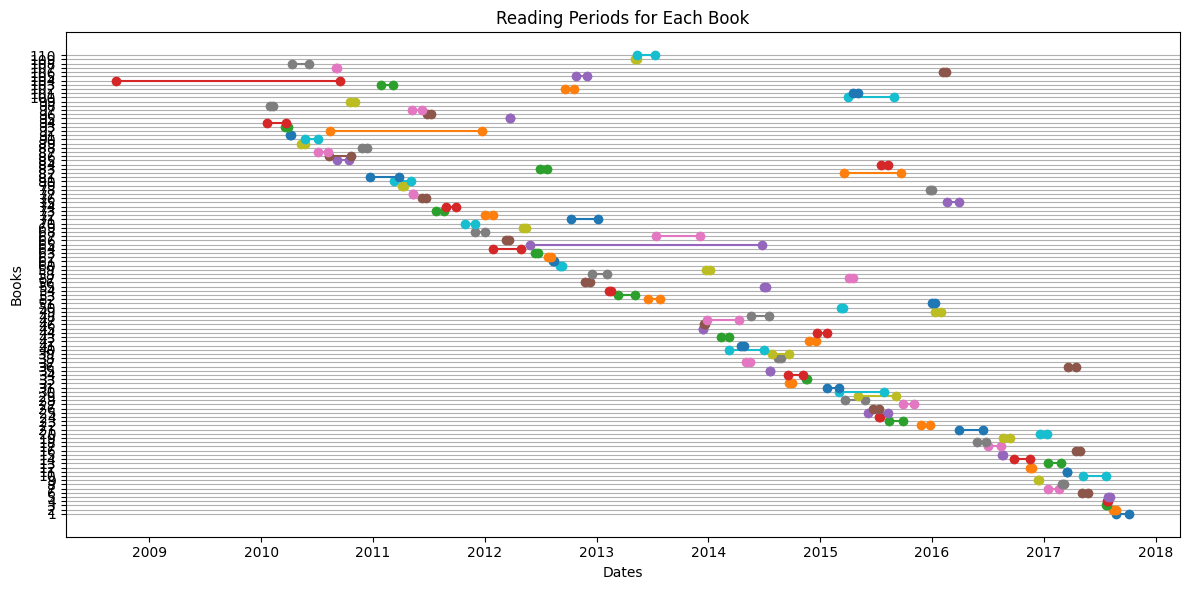

In [23]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date
from pyspark.sql import functions as F

# Assuming your DataFrame is named 'df'
refined_max_books_data = refined_max_books_data.withColumn('read_date', F.to_date(F.unix_timestamp('read_date', 'MMM dd yyyy').cast('timestamp')))
refined_max_books_data = refined_max_books_data.withColumn('started_date', F.to_date(F.unix_timestamp('started_date', 'MMM dd yyyy').cast('timestamp')))

# Collect the data to the driver
data = refined_max_books_data.select('read_date', 'started_date').collect()

# Plotting
plt.figure(figsize=(12, 6))

# Plotting each row with a unique color
for i, row in enumerate(data):
    plt.plot([row['started_date'], row['read_date']], [i, i], marker='o')

plt.xlabel('Dates')
plt.yticks(range(len(data)), range(1, len(data) + 1))
plt.ylabel('Books')
plt.title('Reading Periods for Each Book')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


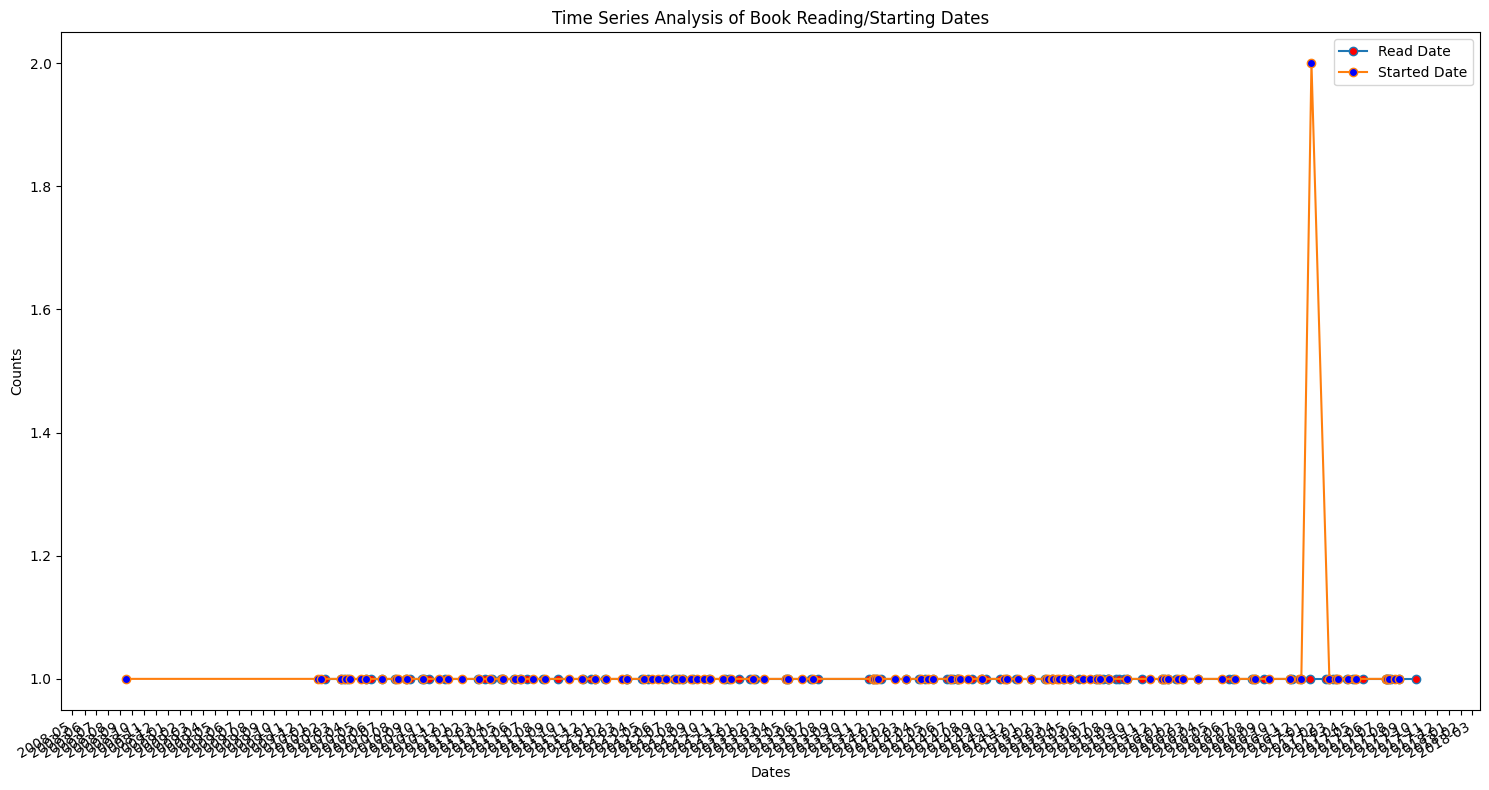

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.sql.functions import to_date
from collections import Counter
from datetime import datetime

# Assuming your DataFrame is named 'df'
refined_max_books_data = refined_max_books_data.withColumn('read_date', to_date(refined_max_books_data['read_date'], 'MMM dd yyyy'))
refined_max_books_data = refined_max_books_data.withColumn('started_date', to_date(refined_max_books_data['started_date'], 'MMM dd yyyy'))

# Collect the data to the driver
data = refined_max_books_data.select('read_date', 'started_date').collect()

# Extracting the dates and counting occurrences
read_date_counts = Counter([row['read_date'] for row in data])
started_date_counts = Counter([row['started_date'] for row in data])

# Separate the dates and counts
read_dates, read_counts = zip(*sorted(read_date_counts.items()))
started_dates, started_counts = zip(*sorted(started_date_counts.items()))

# Plotting
plt.figure(figsize=(15, 8))  # Larger figure size to accommodate for more dates

# Plotting with proper date handling and markers
plt.plot_date(read_dates, read_counts, '-o', label='Read Date', mfc='red')
plt.plot_date(started_dates, started_counts, '-o', label='Started Date', mfc='blue')

# Formatting the x-axis to handle dates better
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

plt.xlabel('Dates')
plt.ylabel('Counts')
plt.title('Time Series Analysis of Book Reading/Starting Dates')
plt.legend()
plt.tight_layout()  # Adjust subplot parameters to give the plot more room
plt.show()

# Genre based time series analysis

In [25]:
file_url = 'https://storage.googleapis.com/nyu-dataproc-hdfs-ingest/goodreads_book_authors.json.gz'

# Read the JSON file into a DataFrame
authors_df = pd.read_json(file_url, lines = True)

In [26]:
spark_authors_df = spark.createDataFrame(authors_df)

# Show the Spark DataFrame
spark_authors_df.show()

+--------------+---------+------------------+-------------------+-------------+
|average_rating|author_id|text_reviews_count|               name|ratings_count|
+--------------+---------+------------------+-------------------+-------------+
|          3.98|   604031|                 7|   Ronald J. Fields|           49|
|          4.08|   626222|             28716|      Anita Diamant|       546796|
|          3.92|    10333|              5075|     Barbara Hambly|       122118|
|          3.68|     9212|             36262|    Jennifer Weiner|       888522|
|          3.82|   149918|                96|      Nigel Pennick|         1740|
|          3.89|  3041852|                85|   Alfred J. Church|          947|
|          4.17|   215594|                 6| Michael Halberstam|           23|
|          4.18|    19158|               486|     Rachel Roberts|        13677|
|          3.99|  5807700|               986|         V.L. Locey|         3130|
|          3.48|  2983296|              

## Genre data import 

In [27]:
import pandas as pd

file_url = 'https://storage.googleapis.com/nyu-dataproc-hdfs-ingest/goodreads_book_genres_initial.json'
df_2 = pd.read_json(file_url, lines = True)
spark_df_2 = spark.createDataFrame(df_2)

In [28]:
spark_df_2.show(truncate=False)

+--------+----------------------------------------------------------------------------------------------------------------------+
|book_id |genres                                                                                                                |
+--------+----------------------------------------------------------------------------------------------------------------------+
|5333265 |{history, historical fiction, biography -> 1}                                                                         |
|1333909 |{fiction -> 219, history, historical fiction, biography -> 5}                                                         |
|7327624 |{fantasy, paranormal -> 31, mystery, thriller, crime -> 1, fiction -> 8, poetry -> 1}                                 |
|6066819 |{romance -> 23, mystery, thriller, crime -> 10, fiction -> 555}                                                       |
|287140  |{non-fiction -> 3}                                                              

In [29]:
spark_df_2.printSchema()

root
 |-- book_id: long (nullable = true)
 |-- genres: map (nullable = true)
 |    |-- key: string
 |    |-- value: long (valueContainsNull = true)



In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col

df = spark_df_2

# Explode the genres map into separate rows
genre_bookid_df = df.select(
    col("book_id"),
    explode(col("genres")).alias("genre", "count")
)
genre_bookid_df.show(truncate = False)

+-------+--------------------------------------+-----+
|book_id|genre                                 |count|
+-------+--------------------------------------+-----+
|5333265|history, historical fiction, biography|1    |
|1333909|fiction                               |219  |
|1333909|history, historical fiction, biography|5    |
|7327624|fantasy, paranormal                   |31   |
|7327624|mystery, thriller, crime              |1    |
|7327624|fiction                               |8    |
|7327624|poetry                                |1    |
|6066819|romance                               |23   |
|6066819|mystery, thriller, crime              |10   |
|6066819|fiction                               |555  |
|287140 |non-fiction                           |3    |
|287141 |fantasy, paranormal                   |1    |
|287141 |history, historical fiction, biography|9    |
|287141 |fiction                               |1    |
|287141 |children                              |6    |
|287141 |y

In [31]:
filtered_df.show(truncate=False)

+--------------------------------+--------+--------------------------------+-------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|user_id                         |book_id |review_id                       |is_read|rating|review_text_incomplete                                                                                                                                                             

In [32]:
joined_df = filtered_df.join(genre_bookid_df, filtered_df.book_id == genre_bookid_df.book_id, "inner").drop(genre_bookid_df.book_id)

# Displaying the resulting DataFrame
joined_df.show()

+--------------------+-------+--------------------+-------+------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|             user_id|book_id|           review_id|is_read|rating|review_text_incomplete|          date_added|        date_updated|             read_at|          started_at|               genre|count|
+--------------------+-------+--------------------+-------+------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|d6804aa6e3a96b8e1...|     22|ad7e9a52ff1c00670...|   true|     2|  Eh...I was excite...|Wed Jun 29 16:57:...|Sun Jul 03 16:44:...|Fri Jul 01 00:00:...|Wed Jun 29 00:00:...|history, historic...|   51|
|d6804aa6e3a96b8e1...|     22|ad7e9a52ff1c00670...|   true|     2|  Eh...I was excite...|Wed Jun 29 16:57:...|Sun Jul 03 16:44:...|Fri Jul 01 00:00:...|Wed Jun 29 00:00:...|         non-fiction|  

In [33]:
from pyspark.sql.functions import substring, concat_ws

# Assuming max_books_data contains the DataFrame for the user with the maximum books read

# Refining read_at and started_at columns to only include the date part in the desired format
joined_df_refined = joined_df \
    .withColumn('read_date', concat_ws(' ',
                                       substring(col('read_at'), 5, 6),
                                       substring(col('read_at'), 27, 4))) \
    .withColumn('started_date', concat_ws(' ',
                                          substring(col('started_at'), 5, 6),
                                          substring(col('started_at'), 27, 4))) \
    .select('user_id', 'book_id', 'rating', 'genre', 'read_date', 'started_date')

# Show the refined DataFrame
joined_df_refined.show(truncate=False)


+--------------------------------+-------+------+--------------------------------------+-----------+------------+
|user_id                         |book_id|rating|genre                                 |read_date  |started_date|
+--------------------------------+-------+------+--------------------------------------+-----------+------------+
|d6804aa6e3a96b8e1104b8b9ac3fe882|22     |2     |history, historical fiction, biography|Jul 01 2011|Jun 29 2011 |
|d6804aa6e3a96b8e1104b8b9ac3fe882|22     |2     |non-fiction                           |Jul 01 2011|Jun 29 2011 |
|ccdf64bdd73b6d5d6436283753690af8|26     |3     |fiction                               |Jul 05 2015|Jun 25 2015 |
|ccdf64bdd73b6d5d6436283753690af8|26     |3     |history, historical fiction, biography|Jul 05 2015|Jun 25 2015 |
|ccdf64bdd73b6d5d6436283753690af8|26     |3     |non-fiction                           |Jul 05 2015|Jun 25 2015 |
|d6804aa6e3a96b8e1104b8b9ac3fe882|26     |3     |fiction                               |

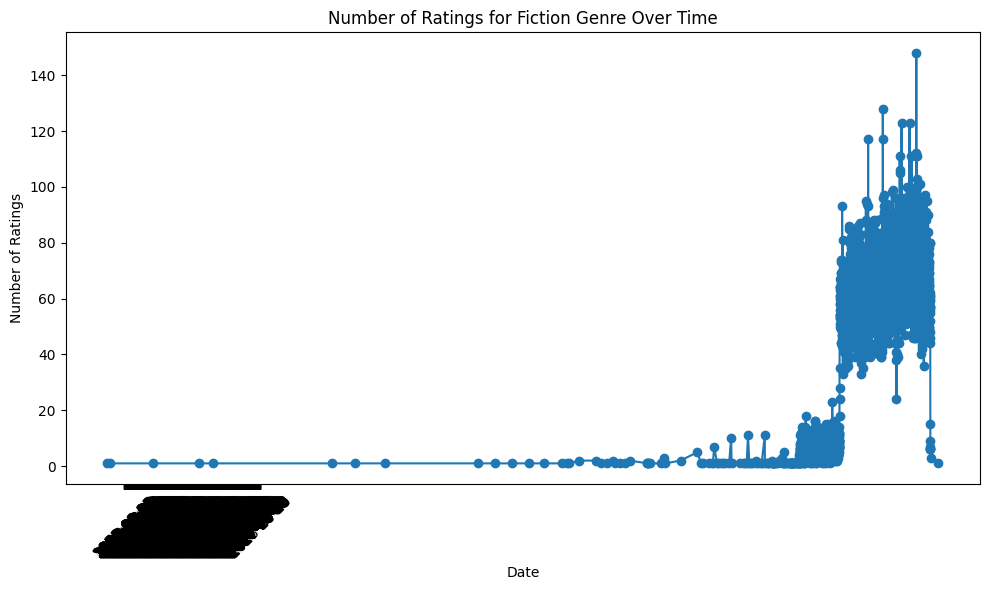

In [35]:
# Assuming your DataFrame is named 'df'
from pyspark.sql.functions import split

# Convert date columns to consistent date format
joined_df_refined = joined_df_refined.withColumn("read_date", to_date("read_date", "MMM dd yyyy"))
joined_df_refined = joined_df_refined.withColumn("started_date", to_date("started_date", "MMM dd yyyy"))

# Explode the genre column to have a separate row for each genre
joined_df_refined = joined_df_refined.withColumn("genre", explode(split("genre", ", ")))

# Perform aggregation on genre and date
result_df = joined_df_refined.groupBy("genre", "read_date").agg({"rating": "avg", "rating": "count"}).orderBy("read_date")

# Visualize the result_df data using suitable visualization libraries (e.g., matplotlib, seaborn)
# For instance, you can create line plots or bar plots to showcase popularity changes for each genre over time

import matplotlib.pyplot as plt

# Assuming 'result_df' contains the aggregated data

# Extract data for a specific genre (e.g., 'fiction') for plotting
genre_data = result_df.filter(result_df['genre'] == 'fiction').orderBy('read_date').collect()

# Extracting x (dates) and y (ratings) values for plotting
dates = [row['read_date'] for row in genre_data]
ratings = [row['count(rating)'] for row in genre_data]  # Extracting the count of ratings

# Plotting the time series for 'fiction' genre
plt.figure(figsize=(10, 6))
plt.plot(dates, ratings, marker='o', linestyle='-')

# Customizing plot labels and title
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings for Fiction Genre Over Time')

# Display the plot
plt.xticks(range(len(dates)), dates, rotation=45)
plt.tight_layout()
plt.show()


In [42]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Assuming 'result_df' contains the aggregated data
plot_df = joined_df_refined.limit(10)

plot_df.show()


+--------------------+-------+------+------------------+----------+------------+
|             user_id|book_id|rating|             genre| read_date|started_date|
+--------------------+-------+------+------------------+----------+------------+
|d6804aa6e3a96b8e1...|     22|     2|           history|2011-07-01|  2011-06-29|
|d6804aa6e3a96b8e1...|     22|     2|historical fiction|2011-07-01|  2011-06-29|
|d6804aa6e3a96b8e1...|     22|     2|         biography|2011-07-01|  2011-06-29|
|d6804aa6e3a96b8e1...|     22|     2|       non-fiction|2011-07-01|  2011-06-29|
|ccdf64bdd73b6d5d6...|     26|     3|           fiction|2015-07-05|  2015-06-25|
|ccdf64bdd73b6d5d6...|     26|     3|           history|2015-07-05|  2015-06-25|
|ccdf64bdd73b6d5d6...|     26|     3|historical fiction|2015-07-05|  2015-06-25|
|ccdf64bdd73b6d5d6...|     26|     3|         biography|2015-07-05|  2015-06-25|
|ccdf64bdd73b6d5d6...|     26|     3|       non-fiction|2015-07-05|  2015-06-25|
|d6804aa6e3a96b8e1...|     2

In [ ]:
# genre_counts = plot_df.groupBy("genre").agg({"rating": "count"})

# # Collect distinct genres
# unique_genres = [row.genre for row in genre_counts.select("genre").distinct().collect()]

# plt.figure(figsize=(12, 8))

# for genre in unique_genres:
#     genre_data = plot_df.filter(col('genre') == genre).orderBy('read_date').collect()
#     dates = [row['read_date'] for row in genre_data]
#     ratings = [row['count(rating)'] for row in genre_data]  # Extracting the count of ratings
    
#     plt.plot(dates, ratings, label=genre)

# plt.xlabel('Date')
# plt.ylabel('Number of Ratings')
# plt.title('Popularity Change of Each Genre Over Time')
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()



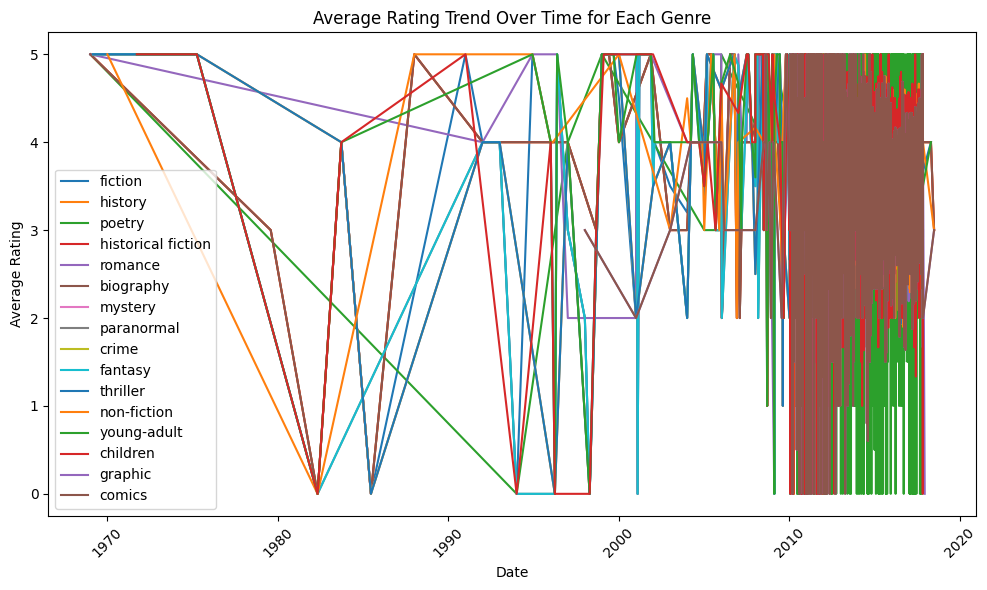

In [47]:
from pyspark.sql.functions import avg

# Group by genre and read_date, calculate average rating, and order by date
result_df = joined_df_refined.groupBy("genre", "read_date").agg(avg("rating").alias("avg_rating")).orderBy("read_date")

# Convert to Pandas DataFrame
result_pd = result_df.toPandas()

# Plotting with Matplotlib
import matplotlib.pyplot as plt

# Plotting for each genre
genres = result_pd['genre'].unique()
plt.figure(figsize=(10, 6))

for genre in genres:
    genre_data = result_pd[result_pd['genre'] == genre]
    plt.plot(genre_data['read_date'], genre_data['avg_rating'], label=genre)

plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.title('Average Rating Trend Over Time for Each Genre')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


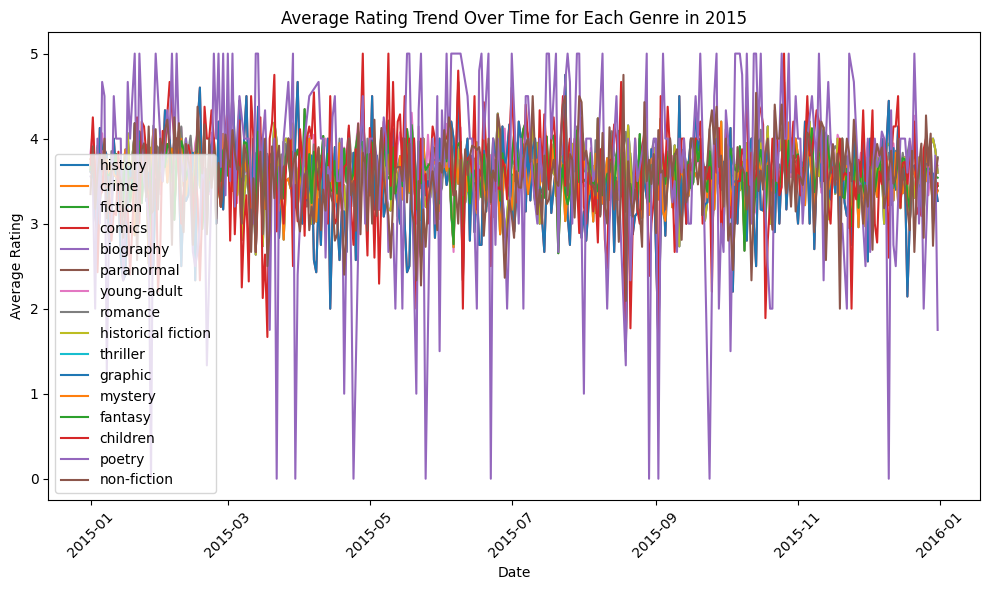

In [58]:
from pyspark.sql.functions import avg, year

# Filter data for a specific year (e.g., 2015)
filtered_df = joined_df_refined.filter(year("read_date") == 2015)

# Group by genre and read_date, calculate average rating, and order by date
result_df = filtered_df.groupBy("genre", "read_date").agg(avg("rating").alias("avg_rating")).orderBy("read_date")

# Convert to Pandas DataFrame
result_pd = result_df.toPandas()

# Plotting with Matplotlib
import matplotlib.pyplot as plt

# Plotting for each genre
genres = result_pd['genre'].unique()
plt.figure(figsize=(10, 6))

for genre in genres:
    genre_data = result_pd[result_pd['genre'] == genre]
    plt.plot(genre_data['read_date'], genre_data['avg_rating'], label=genre)

plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.title('Average Rating Trend Over Time for Each Genre in 2015')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


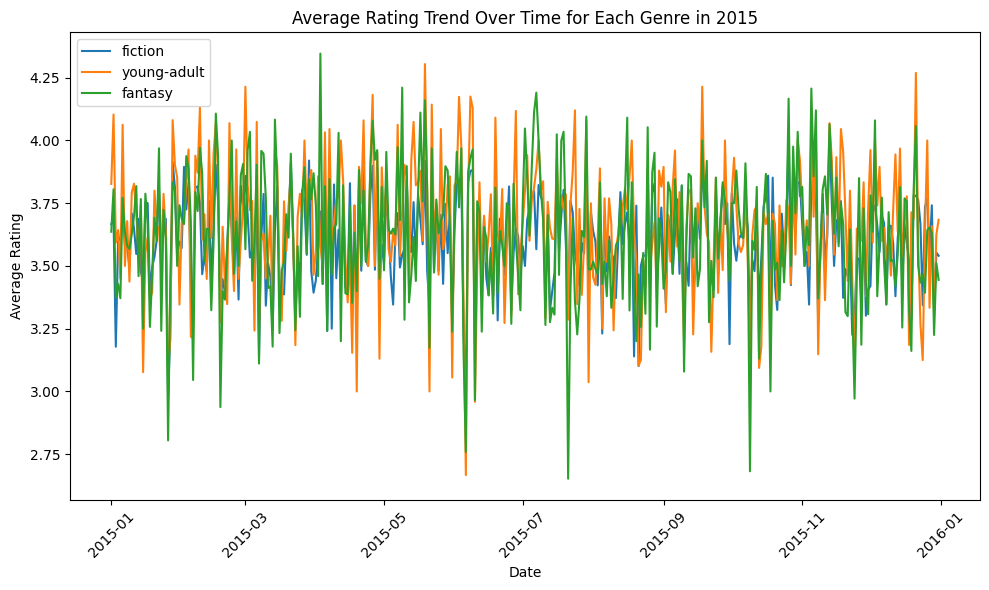

: 

In [59]:
from pyspark.sql.functions import avg, year

# Filter data for a specific year (e.g., 2015)
filtered_df = joined_df_refined.filter(year("read_date") == 2015)

# Group by genre and read_date, calculate average rating, and order by date
result_df = filtered_df.groupBy("genre", "read_date").agg(avg("rating").alias("avg_rating")).orderBy("read_date")

# Convert to Pandas DataFrame
result_pd = result_df.toPandas()

# Plotting with Matplotlib
import matplotlib.pyplot as plt

# Plotting for each genre
genres = result_pd['genre'].unique()
plt.figure(figsize=(10, 6))

selected_genres = ['fiction', 'fantasy', 'young-adult']
    
for genre in genres:
    if genre in selected_genres:    
        genre_data = result_pd[result_pd['genre'] == genre]
        plt.plot(genre_data['read_date'], genre_data['avg_rating'], label=genre)

plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.title('Average Rating Trend Over Time for Each Genre in 2015')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


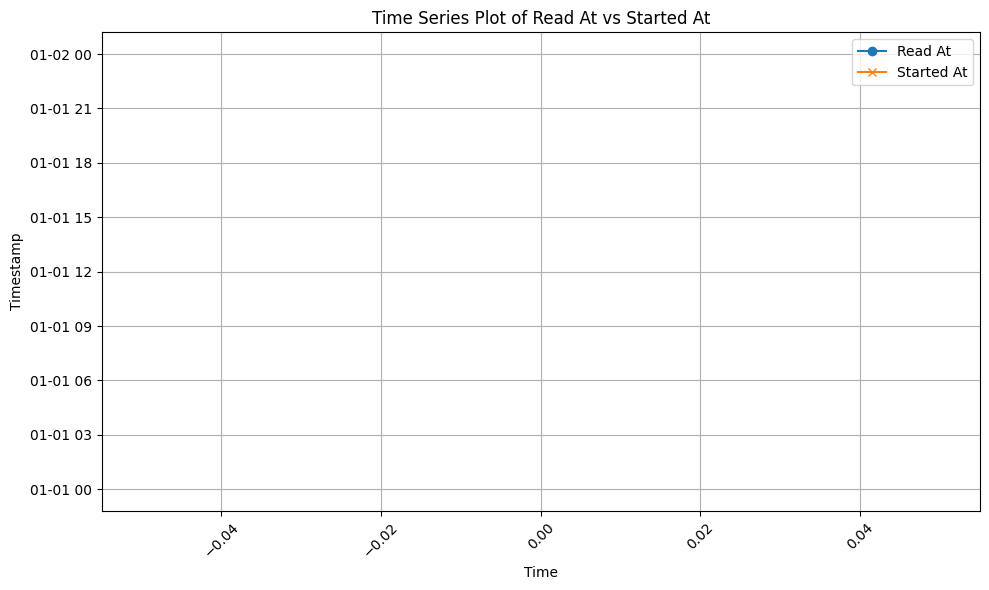

In [ ]:
filtered_data = user_max_reads_data.filter((col('read_at') != '') & (col('started_at') != ''))

# Convert 'read_at' and 'started_at' columns to timestamp format
filtered_data = filtered_data.withColumn('read_at', filtered_data['read_at'].cast('timestamp'))
filtered_data = filtered_data.withColumn('started_at', filtered_data['started_at'].cast('timestamp'))

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_data = filtered_data.select('read_at', 'started_at').toPandas()

# Plotting the time series data
plt.figure(figsize=(10, 6))
plt.plot(pandas_data['read_at'], label='Read At', marker='o', linestyle='-')
plt.plot(pandas_data['started_at'], label='Started At', marker='x', linestyle='-')
plt.title('Time Series Plot of Read At vs Started At')
plt.xlabel('Time')
plt.ylabel('Timestamp')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()